# ResNet

Deeper is better, but you can go only so far without penalizing generalization capability.

### VGG-19

34 CNN layers with 3x3 filters.
* blocks have the same number of filters
* if the feature map is halved by pooling, the number of filters is doubled to preserve the time complexity
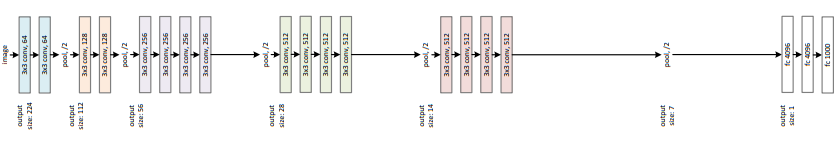
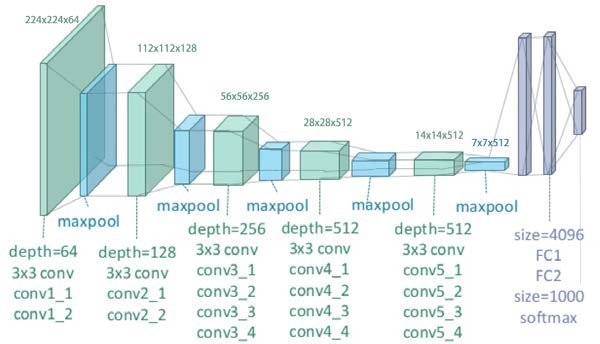

Soon you will encounter vanishing/exploding gradient.

An error gradient is the direction and magnitude calculated during the training of a neural network that is used to update the network weights in the right direction and by the right amount.

**Vanishing gradient**
* error gradients are getting smaller and close to zero making the neural network hard to train 

**Exploding gradient**
* accumulating error gradient in very deep networks to a very large corrections causing unstable training

Adding more layers could result in worse accuracy.
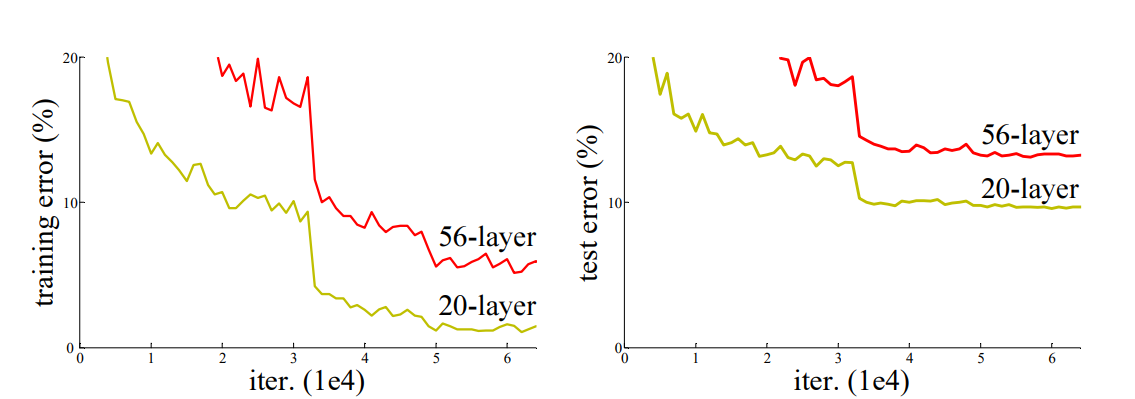

### How to enable deep model to not perfrom worse than shallow one?
It looks like optimizers have problems to map identity function to multiple nonlinear layers.

### Introducing Residual blocks
Using skip connections to be able to train deeper networks.

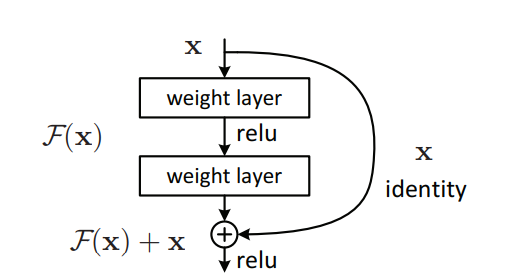

It allows network to easily map identity functions - if weights are close to zero, it just "skips" the layers and output is close the input.

Network can start making progress even if some of the layers did not start learning yet.

Blocks are quite simple, they are typically composed of:
* 2 convolutional layers with 3 × 3 kernels and without pooling
* Batch Normalization - standardize layer outputs
* ReLu activation
* preserving spatial dimensions - (stride 1, "same" padding)

### ResNet-34

Residual blocks are stacked together and allow us to create very deep network.

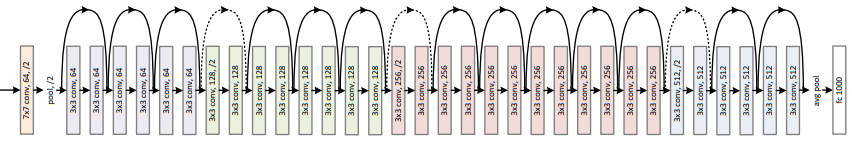

The dotted line is used for translation between doubling the filter count. Upsampling is done by employing 1x1 convolutions with stride = 2.

34 is original ResNet length, however, there are modifications with different layer count, for example ResNet-152, that introduce some modification to keep parameters count on reasonable values (like introducing 1x1 convolution bottlenecks in residual units helping reducing dimensions).

## Implementation of simple residual unit in Keras

Bellow is simplified version of ResNet:
* it uses just a two residual unit
* residual units do not change dimensionality

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, MaxPool2D

### Add layer
Sums up layers outputs.

Difference between **Add** and **Concatenate** layers:
* Concatenate is just appending the tensors together, it allows later layers to work with all the information - `[4]+[4]=[8]`
* Add is adding the outputs, it is mainly used for "correction" like in residual units - `[4]+[4]=[4]`

We are creating residual block by subclassing Model to honor DRY principle.

In [ ]:
class ResidualBlock(Model):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__(name='')
        # just define objects we want to use
        
        # first convolution
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        # batch normalization for the first convolution
        self.bn1 = BatchNormalization()
        
        # second convolution
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        # batch normalization for the second convolution
        self.bn2 = BatchNormalization()
        
        # relu activation - it does not learn any parameters, so it does not need to be instantiated multiple times
        self.act = Activation('relu')
        # Add layer
        self.add = Add()
    
    def call(self, input_tensor):
        # create residual unit architecture
        x = self.conv1(input_tensor)
        # batch normalization is used before activation function
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)
        # skip connection
        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

Setting up ResNet with two residual units.

In [ ]:
class ResNet(Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        # first layers are defined in linear fashion
        self.conv = Conv2D(64, 7, padding='same')
        self.bn = BatchNormalization()
        self.act = Activation('relu')
        self.max_pool = MaxPool2D((3, 3))

        # Use the Residual blocks
        self.id1a = ResidualBlock(64, 3)
        self.id1b = ResidualBlock(64, 3)        
        
        self.global_pool = GlobalAveragePooling2D()
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # first layers
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)
        
        # flattening the output by pooling
        x = self.global_pool(x)
        
        return self.classifier(x)

## Using simple ResNet for MNIST classification

Testing our implementation on MNIST dataset.

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

It is better to explictly expand the input dimensions - Con2D expects 4D inputs (batch, rows, cols, channels).

In case of 1 channel inputs Keras expands it for us, but if we would like to use 3 channels, it would return an error.

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
%%time
# create a ResNet instance with 10 output units for MNIST
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = resnet.fit(x_train, y_train, validation_split = 0.2, epochs=5)

In [ ]:
resnet.summary()

### Accuracy

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('accuracy')
plt.grid(True)

### Loss function

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss function')
plt.grid(True)

### Model evaluation

In [ ]:
result = resnet.evaluate(x_test, y_test)
print(f'accuracy: {result[1]*100:.2f}%')